Running PGD: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt
PGD Top-1: 7.20%, Top-5: 42.20%
Mean L∞: 0.01000, Max L∞: 0.01000 (ε = 0.02)


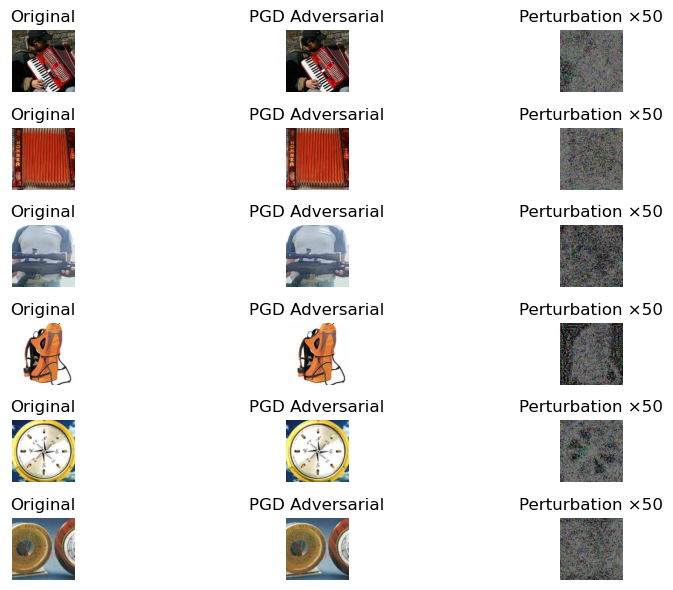

In [1]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.02
alpha = 0.005
steps = 2
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

# Step 1: Extract label indices from JSON
with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

# Step 2: Download full synset (index → WNID) map
url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

# Step 3: Load dataset and map folders to global indices
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found in the dataset.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- PGD Attack ---
def pgd_attack(model, x, y, eps, alpha, steps):
    x_orig = x.clone().detach().to(device)
    x_adv = x_orig.clone().detach()
    y = y.to(device)

    for _ in range(steps):
        x_adv.requires_grad = True
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.clamp(x_adv, x_orig - eps, x_orig + eps)
        x_adv = torch.max(torch.min(x_adv, (1.0 - mean_vals) / std_vals), (0.0 - mean_vals) / std_vals)
        x_adv = x_adv.detach()

    return x_adv

# --- Run attack and collect results ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running PGD"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv = pgd_attack(model, x, y, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)
    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            orig_cpu = x[i].cpu()
            adv_cpu = adv[i].cpu()
            delta = adv_cpu - orig_cpu
            triplets.append((orig_cpu, adv_cpu, delta))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

# --- Save to disk ---
os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set2.pt")
print("Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"PGD Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance check ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()

fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("PGD Adversarial")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis("off")
plt.tight_layout()
os.makedirs("PGD_Visualizations", exist_ok=True)
plt.savefig("PGD_Visualizations/pgd_visualization_2.png")
plt.show()


Running PGD: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].


PGD Top-1: 0.20%, Top-5: 14.00%
Mean L∞: 0.02000, Max L∞: 0.02000 (ε = 0.02)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24999678..1.000005].


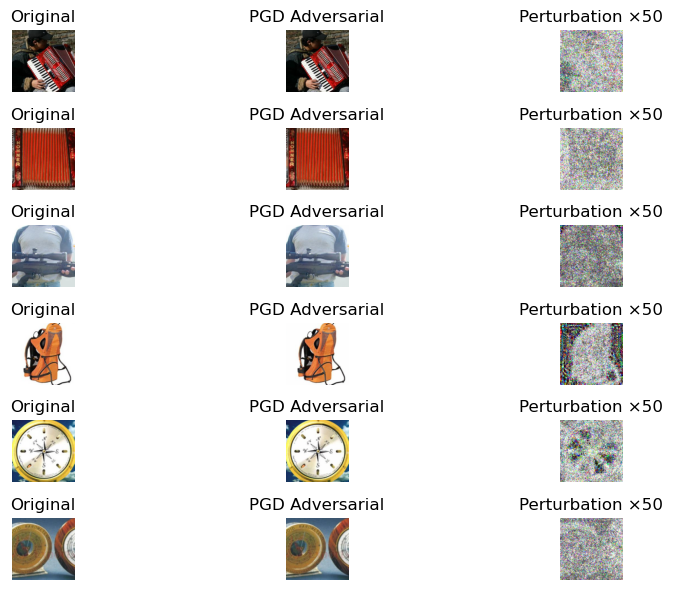

In [2]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.02
alpha = 0.005
steps = 5
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

# Step 1: Extract label indices from JSON
with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

# Step 2: Download full synset (index → WNID) map
url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

# Step 3: Load dataset and map folders to global indices
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found in the dataset.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- PGD Attack ---
def pgd_attack(model, x, y, eps, alpha, steps):
    x_orig = x.clone().detach().to(device)
    x_adv = x_orig.clone().detach()
    y = y.to(device)

    for _ in range(steps):
        x_adv.requires_grad = True
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.clamp(x_adv, x_orig - eps, x_orig + eps)
        x_adv = torch.max(torch.min(x_adv, (1.0 - mean_vals) / std_vals), (0.0 - mean_vals) / std_vals)
        x_adv = x_adv.detach()

    return x_adv

# --- Run attack and collect results ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running PGD"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv = pgd_attack(model, x, y, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)
    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            orig_cpu = x[i].cpu()
            adv_cpu = adv[i].cpu()
            delta = adv_cpu - orig_cpu
            triplets.append((orig_cpu, adv_cpu, delta))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

# --- Save to disk ---
os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set2.pt")
print("Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"PGD Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance check ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()

fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("PGD Adversarial")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis("off")
plt.tight_layout()
os.makedirs("PGD_Visualizations", exist_ok=True)
plt.savefig("PGD_Visualizations/pgd_visualization_5.png")
plt.show()


Running PGD: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].


PGD Top-1: 0.00%, Top-5: 10.40%
Mean L∞: 0.02000, Max L∞: 0.02000 (ε = 0.02)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].


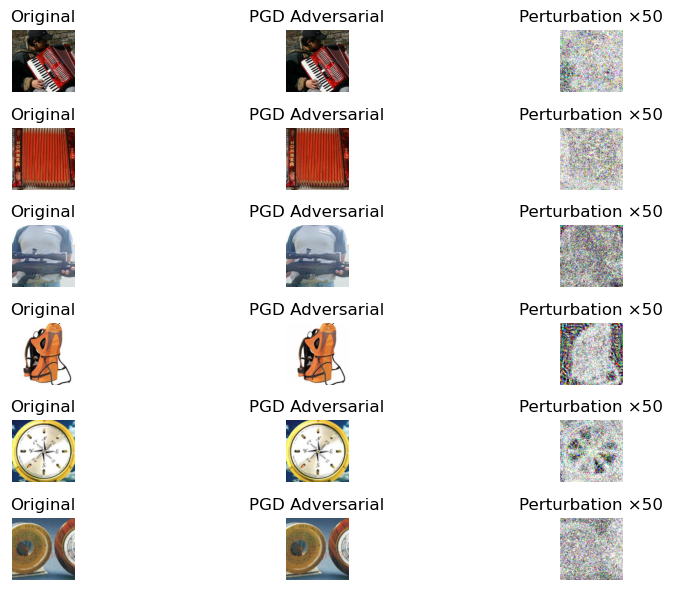

In [3]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.02
alpha = 0.005
steps = 8
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

# Step 1: Extract label indices from JSON
with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

# Step 2: Download full synset (index → WNID) map
url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

# Step 3: Load dataset and map folders to global indices
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found in the dataset.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- PGD Attack ---
def pgd_attack(model, x, y, eps, alpha, steps):
    x_orig = x.clone().detach().to(device)
    x_adv = x_orig.clone().detach()
    y = y.to(device)

    for _ in range(steps):
        x_adv.requires_grad = True
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.clamp(x_adv, x_orig - eps, x_orig + eps)
        x_adv = torch.max(torch.min(x_adv, (1.0 - mean_vals) / std_vals), (0.0 - mean_vals) / std_vals)
        x_adv = x_adv.detach()

    return x_adv

# --- Run attack and collect results ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running PGD"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv = pgd_attack(model, x, y, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)
    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            orig_cpu = x[i].cpu()
            adv_cpu = adv[i].cpu()
            delta = adv_cpu - orig_cpu
            triplets.append((orig_cpu, adv_cpu, delta))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

# --- Save to disk ---
os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set2.pt")
print("Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"PGD Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance check ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()

fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("PGD Adversarial")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis("off")
plt.tight_layout()
os.makedirs("PGD_Visualizations", exist_ok=True)
plt.savefig("PGD_Visualizations/pgd_visualization_8.png")
plt.show()


Running PGD: 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].


PGD Top-1: 0.00%, Top-5: 10.00%
Mean L∞: 0.02000, Max L∞: 0.02000 (ε = 0.02)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.000005].


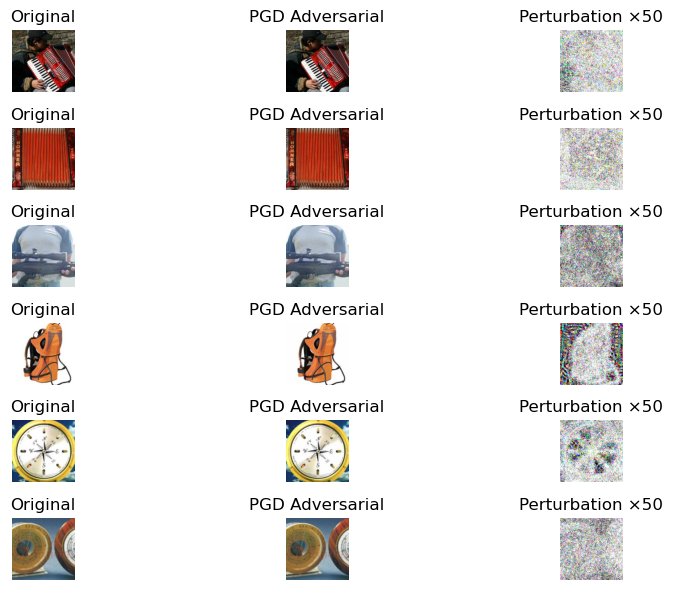

In [4]:
import os, json, ast, requests
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Config ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epsilon = 0.02
alpha = 0.005
steps = 10
BATCH_SIZE = 64

mean_vals = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
std_vals  = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

# --- Load ResNet-34 ---
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device).eval()

# --- Load clean dataset (used in Task 1) ---
DATASET_PATH = "./test_dataset"
LABELS_JSON = os.path.join(DATASET_PATH, "labels_list.json")

# Step 1: Extract label indices from JSON
with open(LABELS_JSON, "r") as f:
    entries = json.load(f)
subset_indices = [int(e.split(":")[0]) for e in entries]

# Step 2: Download full synset (index → WNID) map
url = "https://gist.githubusercontent.com/fnielsen/4a5c94eaa6dcdf29b7a62d886f540372/raw/imagenet_label_to_wordnet_synset.txt"
synset_text = requests.get(url).text
synset_map = ast.literal_eval(synset_text)

idx_to_wnid = {}
for idx_str, info in synset_map.items():
    idx = int(idx_str)
    if idx in subset_indices:
        wnid = "n" + info["id"].split("-")[0]
        idx_to_wnid[idx] = wnid
wnid_to_global = {wnid: idx for idx, wnid in idx_to_wnid.items()}
valid_wnids = set(wnid_to_global.keys())

# Step 3: Load dataset and map folders to global indices
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals[:, 0, 0], std=std_vals[:, 0, 0])
])

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d in valid_wnids]
        if not dirs:
            raise ValueError("No matching WNID folders found in the dataset.")
        dirs.sort()
        return dirs, {cls_name: i for i, cls_name in enumerate(dirs)}

base_ds = FilteredImageFolder(DATASET_PATH, transform=transform)
folder_to_global = {i: wnid_to_global[wnid] for i, wnid in enumerate(base_ds.classes)}

class SubsetDataset(Dataset):
    def __init__(self, base_ds, index_map):
        self.base = base_ds
        self.index_map = index_map
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        img, folder_idx = self.base[idx]
        return img, self.index_map[folder_idx]

dataset = SubsetDataset(base_ds, folder_to_global)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- PGD Attack ---
def pgd_attack(model, x, y, eps, alpha, steps):
    x_orig = x.clone().detach().to(device)
    x_adv = x_orig.clone().detach()
    y = y.to(device)

    for _ in range(steps):
        x_adv.requires_grad = True
        logits = model(x_adv)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        grad = x_adv.grad.detach()
        x_adv = x_adv + alpha * grad.sign()
        x_adv = torch.clamp(x_adv, x_orig - eps, x_orig + eps)
        x_adv = torch.max(torch.min(x_adv, (1.0 - mean_vals) / std_vals), (0.0 - mean_vals) / std_vals)
        x_adv = x_adv.detach()

    return x_adv

# --- Run attack and collect results ---
adv_imgs, adv_lbls, orig_imgs, triplets = [], [], [], []

for x, y in tqdm(loader, desc="Running PGD"):
    orig_imgs.append(x.clone())
    x = x.to(device)
    adv = pgd_attack(model, x, y, epsilon, alpha, steps)
    adv_imgs.append(adv.cpu())
    adv_lbls.append(y)
    if len(triplets) < 5:
        for i in range(min(2, x.size(0))):
            orig_cpu = x[i].cpu()
            adv_cpu = adv[i].cpu()
            delta = adv_cpu - orig_cpu
            triplets.append((orig_cpu, adv_cpu, delta))

adv_imgs_tensor = torch.cat(adv_imgs)
adv_lbls_tensor = torch.cat(adv_lbls)
orig_tensor = torch.cat(orig_imgs)

# --- Save to disk ---
os.makedirs("AdversarialTestSets", exist_ok=True)
torch.save({"images": adv_imgs_tensor, "labels": adv_lbls_tensor}, "AdversarialTestSets/adv_test_set2.pt")
print("Saved PGD dataset to AdversarialTestSets/adv_test_set2.pt")

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, loader, topk=(1, 5)):
    correct, total = {k: 0 for k in topk}, {k: 0 for k in topk}
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, preds = logits.topk(max(topk), dim=1)
        for k in topk:
            correct[k] += (preds[:, :k] == y.unsqueeze(1)).any(dim=1).sum().item()
            total[k] += y.size(0)
    return {k: correct[k] / total[k] for k in topk}

acc = evaluate(model, DataLoader(TensorDataset(adv_imgs_tensor, adv_lbls_tensor), batch_size=BATCH_SIZE))
print(f"PGD Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")

# --- L∞ Distance check ---
linf = (adv_imgs_tensor - orig_tensor).abs().view(len(orig_tensor), -1).max(dim=1)[0]
print(f"Mean L∞: {linf.mean():.5f}, Max L∞: {linf.max():.5f} (ε = {epsilon})")

# --- Visualize ---
def denorm(img): return (img * std_vals.cpu()) + mean_vals.cpu()

fig, axes = plt.subplots(len(triplets), 3, figsize=(10, 6))
for i, (o, a, d) in enumerate(triplets):
    axes[i][0].imshow(denorm(o).permute(1, 2, 0).clip(0, 1)); axes[i][0].set_title("Original")
    axes[i][1].imshow(denorm(a).permute(1, 2, 0).clip(0, 1)); axes[i][1].set_title("PGD Adversarial")
    axes[i][2].imshow((d).permute(1, 2, 0).abs().clip(0, 0.05) * 50); axes[i][2].set_title("Perturbation ×50")
    for ax in axes[i]: ax.axis("off")
plt.tight_layout()
os.makedirs("PGD_Visualizations", exist_ok=True)
plt.savefig("PGD_Visualizations/pgd_visualization_10.png")
plt.show()


In [5]:
import zipfile
import os

def zip_folder(folder_path, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Usage
zip_folder("PGD_Visualizations", "PGD_Visualizations.zip")
print("Zipped PGD_Visualizations to PGD_Visualizations.zip")


Zipped PGD_Visualizations to PGD_Visualizations.zip
